In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from math import sqrt
from numpy import round, clip
from sklearn.model_selection import cross_val_score
print("environment checked!")

environment checked!


In [54]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import optuna
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingRegressor
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

# 数据部分

比赛数据导入，重命名特征列，方便理解，实验数据为data，预测数据为pred_data

In [173]:
# 导入比赛数据（train,test)以及原始数据（uci-dataset）
train_data = pd.read_csv("./data/playground-series-s4e4/train.csv",index_col="id")
pred_data = pd.read_csv("./data/playground-series-s4e4/test.csv",index_col="id")
orig_data = pd.read_csv("./data/abalone/abalone.data")

columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
train_data.columns = orig_data.columns =  columns
data = pd.concat([train_data, orig_data], axis=0)
pred_data.columns = columns[:-1]

data.head()
# pred_data.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [ ]:
# 查看 "Height" 为 0 的条目
height_zero_entries = data[data['Height'] < 0.002]
print(height_zero_entries)
height_zero_entries1 = pred_data[pred_data['Height'] < 0.002]
print(height_zero_entries1)
# data.drop(data[data['Height'] == 0].index, inplace=True)
# data.describe()

独热编码Sex

In [4]:
data_encoded = pd.get_dummies(data, columns=['Sex'], dtype=int)
data_encoded.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,1,0,0
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,1,0,0
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0,1,0
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0,0,1
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0,1,0


二元编码，因为FM分布几乎一样，弃用，不如独热编码

In [ ]:
# # 创建一个新列，根据'Sex'列的值用1或0填充
# data['Sex_encoded'] = data['Sex'].apply(lambda x: 1 if x in ['F', 'M'] else 0)
# 
# # 现在，您可以选择删除原始的'Sex'列
# data.drop('Sex', axis=1, inplace=True)
# 
# # 展示前几行以确认结果
# data.head()
# data_bin = data

合成特征，比如体积比较有意义，壳密度，长宽比，壳重和去壳重量比，后续补充对Height的裁剪,体积有0怎么办
正好不算密度：保留：
1. 体积?也考虑不要
2. 壳重/去壳重

In [174]:
data["Volume"] = data["Length"] * data["Diameter"] * data["Height"]
data["ShellRatio"] = data["Shell_weight"] / data["Shucked_weight"]
data = pd.get_dummies(data, columns=['Sex'], dtype=int)

pred_data = pd.get_dummies(pred_data, columns=['Sex'], dtype=int)
pred_data["ShellRatio"] = pred_data["Shell_weight"] / pred_data["Shucked_weight"]
data.head()
pred_data.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_I,Sex_M,ShellRatio
id,,,,,,,,,,,
90615,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,0,0,1,0.485853
90616,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,0,0,1,0.574713
90617,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,0,0,1,0.682270
90618,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,0,0,1,0.666667
90619,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,0,1,0,0.666667


In [ ]:
# Height 有 0 值
# data_encoded["Height"] = data_encoded["Height"].clip(upper=0.2,lower=0.02)
data_encoded["Volume"] = data_encoded["Length"] * data_encoded["Diameter"] * data_encoded["Height"]
# data_encoded["Density"] = data_encoded["Shell_weight"] / data_encoded["Volume"]
# data_encoded["AspectRatio"] = data_encoded["Length"] / data_encoded["Diameter"]
data_encoded["ShellRatio"] = data_encoded["Shell_weight"] / data_encoded["Shucked_weight"]
data_encoded.head()

计算相关性,最后结果只有体积和壳重比比较好。很奇怪，性别为什么相关性差，暂时保留

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
mask = np.triu(np.ones_like(data_encoded.corr()))
plt.figure(figsize=(20,12))
sns.heatmap(data_encoded.corr(), cmap="viridis_r", annot=True, mask=mask,vmin=-1,vmax=1);

In [176]:
# 原始：data
# 独热编码:data_encoded
# 2元编码：data_bin
# 结论，独热编码效果最好
features=['Sex_F', 'Sex_M', 'Sex_I', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight',  "ShellRatio"]
X = data[features]
y = data.Rings
pred_data = pred_data[features]
X.head()

,Sex_F,Sex_M,Sex_I,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,ShellRatio
0,1,0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,0.730594
1,1,0,0,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,0.698690
2,0,0,1,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,0.909091
3,0,1,0,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,0.665779
4,0,0,1,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,0.534506


# 模型部分

三个baseline models
xgboost,lightgbm,catboost

In [10]:
xgbmodel = xgb.XGBRegressor(random_state=42)
print("CV RMSLE score of XGB is ",np.sqrt(-cross_val_score(xgbmodel,X,y,cv=4, scoring = 'neg_mean_squared_log_error').mean()))

CV RMSLE score of XGB is  0.15113524093568245


In [11]:
lgbmmodel = LGBMRegressor(random_state=42, verbose=-1)
print("CV RMSLE score of LGBM is ",np.sqrt(-cross_val_score(lgbmmodel,X,y,cv=4, scoring = 'neg_mean_squared_log_error').mean()))

CV RMSLE score of LGBM is  0.15130386462268103


In [12]:
catmodel = CatBoostRegressor(random_state=42, verbose=0)
print("CV RMSLE score of CAT is ",np.sqrt(-cross_val_score(catmodel,X,y,cv=4, scoring = 'neg_mean_squared_log_error').mean()))

CV RMSLE score of CAT is  0.15020999220414322


# Optuna-Tuning Models

## XGBoost参数设置

In [52]:
# 自定义评分函数
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# 创建评分对象
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# 定义交叉验证策略
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# 在Optuna的目标函数中使用交叉验证
def xgb_objective(trial):
    params = {
        "eta": trial.suggest_float("eta", 0.01, 1.0),
        "gamma": 0.0,
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_child_weight": trial.suggest_float("min_child_weight", 1., 50.),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("lambda", 1.0, 100.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000)
    }
    
    xgb_reg = TransformedTargetRegressor(xgb.XGBRegressor(**params, objective='reg:squarederror', grow_policy='lossguide',
                                                         tree_method="hist", random_state=42),
                                                         func=np.log1p,
                                                         inverse_func=np.expm1)
    # 使用交叉验证获取得分
    val_scores = cross_val_score(xgb_reg, X, y, scoring=rmsle_scorer, cv=kf)

    # 计算平均分数
    avg_score = -np.mean(val_scores)
    
    return avg_score  # 因为rmsle_scorer中设置了greater_is_better=False，返回负的RMSLE分数，Optuna默认是越小越好

sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization
xgb_study = optuna.create_study(direction = 'minimize', study_name="XgbRegressor", sampler=sampler)

[I 2024-04-29 09:53:24,985] A new study created in memory with name: XgbRegressor


第一个xgb模型

In [53]:
TUNE = True
if TUNE:
    xgb_study.optimize(xgb_objective, n_trials=500)

[I 2024-04-29 09:53:33,740] Trial 0 finished with value: 0.16294673253501057 and parameters: {'eta': 0.3807947176588889, 'max_depth': 20, 'min_child_weight': 36.86770314875885, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'lambda': 16.443457513284063, 'n_estimators': 152}. Best is trial 0 with value: 0.16294673253501057.
[I 2024-04-29 09:53:43,645] Trial 1 finished with value: 0.1823673820251488 and parameters: {'eta': 0.8675143843171859, 'max_depth': 13, 'min_child_weight': 35.69555631200623, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'lambda': 83.41182143924175, 'n_estimators': 291}. Best is trial 0 with value: 0.16294673253501057.
[I 2024-04-29 09:53:49,724] Trial 2 finished with value: 0.15146406461092773 and parameters: {'eta': 0.19000671753502962, 'max_depth': 6, 'min_child_weight': 15.907869905017348, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'lambda': 29.83168487960615, 'n_estimators': 651}.


Trial 103 finished with value: 0.1495461254456984 and parameters: {'eta': 0.02308361391151405, 'max_depth': 13, 'min_child_weight': 23.14406615585, 'subsample': 0.9345699075833176, 'colsample_bytree': 0.6061293579178482, 'lambda': 56.965196488197826, 'n_estimators': 896}. Best is trial 103 with value: 0.1495461254456984.

Trial 366 finished with value: 0.14938249893623345 and parameters: {'eta': 0.04442469791266492, 'max_depth': 8, 'min_child_weight': 36.973745700412756, 'subsample': 0.9581189396751842, 'colsample_bytree': 0.5318303726053835, 'lambda': 24.509386010454058, 'n_estimators': 765}. Best is trial 366 with value: 0.14938249893623345.

Trial 382 finished with value: 0.14934930132564278 and parameters: {'eta': 0.04823193022921833, 'max_depth': 8, 'min_child_weight': 26.58149097015466, 'subsample': 0.9432300524707186, 'colsample_bytree': 0.5265780725732072, 'lambda': 32.855491079399506, 'n_estimators': 841}. Best is trial 382 with value: 0.14934930132564278.
网站：
    'eta': 0.1006321838798394,
    'max_depth': 6,
    'min_child_weight': 27.999752791085136,
    'subsample': 0.7344797943645852,
    'colsample_bytree': 0.5389765810810496,
    'lambda': 79.62358968148187,
    'n_estimators': 407
    
xgb_best_params_2 = {
    'eta': 0.08999645298052271,
    'max_depth': 6,
    'min_child_weight': 2.088127882610971,
    'subsample': 0.7725806961689413,
    'colsample_bytree': 0.9163306027660207,
    'lambda': 5.356530752285997,
    'n_estimators': 652
}

In [68]:
print(xgb_study.best_params)

{'eta': 0.04823193022921833, 'max_depth': 8, 'min_child_weight': 26.58149097015466, 'subsample': 0.9432300524707186, 'colsample_bytree': 0.5265780725732072, 'lambda': 32.855491079399506, 'n_estimators': 841}


In [84]:
xgb_best_params_1 = {
'eta': 0.04823193022921833, 'max_depth': 8, 'min_child_weight': 26.58149097015466, 'subsample': 0.9432300524707186, 'colsample_bytree': 0.5265780725732072, 'lambda': 32.855491079399506, 'n_estimators': 841
}

In [85]:
xgb_reg_1 = TransformedTargetRegressor(xgb.XGBRegressor(**xgb_best_params_1, objective='reg:squarederror', grow_policy='lossguide',
                                                 tree_method="hist", random_state=42, gamma=0.0),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)

In [86]:
print("CV RMSLE score of xgb_reg_1 is ",np.sqrt(-cross_val_score(xgb_reg_1,X,y,cv=4, scoring = 'neg_mean_squared_log_error').mean()))

CV RMSLE score of xgb_reg_1 is  0.14946488758038495


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [87]:
xgb_reg_train_1 = TransformedTargetRegressor(xgb.XGBRegressor(**xgb_best_params_1, objective='reg:squarederror', grow_policy='lossguide',
                                                 tree_method="hist", random_state=42, gamma=0.0),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)
xgb_reg_train_1.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=0.5265780725732072,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eta=0.04823193022921833,
                                                  eval_metric=None,
                                                  feature_types=None, gamma=0.0,
                                                  gpu_i...
                                                  grow_policy='lossguide',
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  lambda=32.855491079399506,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=8, max_leaves=None,
                                                  min_child_weight=26.58149097015466,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=841, n_jobs=None,
                                                  num_parallel_tree=None, ...))

In [88]:
mean_squared_log_error(y_valid, xgb_reg_train_1.predict(X_valid), squared=False)

0.1468877446649307

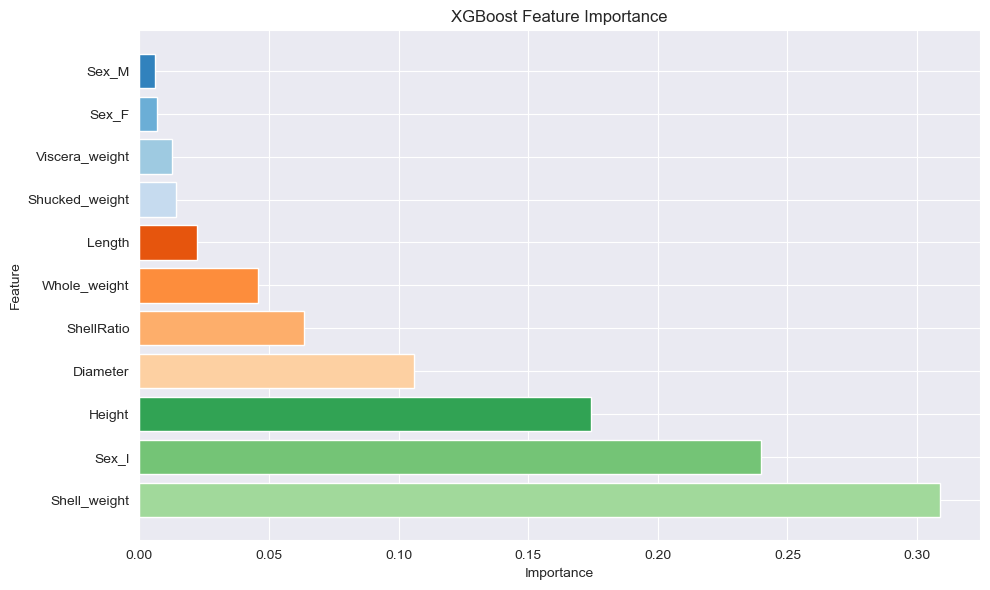

In [132]:
feature_importance = xgb_reg_train_1.regressor_.feature_importances_
feature_names = X.columns

sorted_indices = feature_importance.argsort()
sorted_importance = feature_importance[sorted_indices]
sorted_features = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
colors = plt.cm.tab20c.colors[:len(sorted_features)]  
plt.barh(sorted_features, sorted_importance, color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis() 
plt.tight_layout()  
plt.show()

## LightGBM

In [55]:
def lgbm_objective(trial):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
        "verbosity": -1,
        "random_state": 42,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "n_estimators": trial.suggest_int("n_estimators", 400, 1000),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
        "max_depth": trial.suggest_int("max_depth", 6, 14),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 70),
        "num_leaves": trial.suggest_int("num_leaves", 30, 100),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.1, 1.0)
    }
    
    lgb_reg = LGBMRegressor(**param)
    # 使用交叉验证获取得分
    val_scores = cross_val_score(lgb_reg, X, y, scoring=rmsle_scorer, cv=kf)

    # 计算平均分数
    avg_score = -np.mean(val_scores)
    
    return avg_score  # 因为rmsle_scorer中设置了greater_is_better=False，返回负的RMSLE分数，Optuna默认是越小越好
    

# Set up the sampler for Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

# Create a study object for Optuna optimization
lgbm_study = optuna.create_study(direction="minimize", sampler=sampler)

[I 2024-04-29 12:18:40,381] A new study created in memory with name: no-name-cc8f22ef-2310-4eb4-a86f-a1f56c4e1855


In [56]:
if TUNE:
    # Run the optimization process
    lgbm_study.optimize(lambda trial: lgbm_objective(trial), n_trials=200)

    # Get the best parameters after optimization
    lgbm_best_params = lgbm_study.best_params

    print('='*50)
    print(lgbm_best_params)

[I 2024-04-29 12:18:44,790] Trial 0 finished with value: 0.15001238040446252 and parameters: {'learning_rate': 0.0249816047538945, 'n_estimators': 971, 'lambda_l1': 0.012319939418114049, 'lambda_l2': 0.04394633936788146, 'max_depth': 7, 'colsample_bytree': 0.3935967122017216, 'subsample': 0.8116167224336399, 'min_child_samples': 62, 'num_leaves': 72, 'min_split_gain': 0.737265320016441}. Best is trial 0 with value: 0.15001238040446252.
[I 2024-04-29 12:18:50,423] Trial 1 finished with value: 0.15026868666343546 and parameters: {'learning_rate': 0.010823379771832098, 'n_estimators': 982, 'lambda_l1': 0.013324426408004218, 'lambda_l2': 0.028493564427131045, 'max_depth': 7, 'colsample_bytree': 0.41004270591206027, 'subsample': 0.8608484485919076, 'min_child_samples': 42, 'num_leaves': 60, 'min_split_gain': 0.36210622617823773}. Best is trial 0 with value: 0.15001238040446252.
[I 2024-04-29 12:18:53,203] Trial 2 finished with value: 0.14985726690523388 and parameters: {'learning_rate': 0.0

{'learning_rate': 0.03145145630381439, 'n_estimators': 996, 'lambda_l1': 0.009005545129316126, 'lambda_l2': 0.03519849993125654, 'max_depth': 12, 'colsample_bytree': 0.4436804582753455, 'subsample': 0.8435839525805869, 'min_child_samples': 54, 'num_leaves': 59, 'min_split_gain': 0.45629835685457265}


In [111]:
lgb_params_1 = {
    'learning_rate': 0.03145145630381439,
    'n_estimators': 996,
    'reg_lambda': 0.009005545129316126,
    'reg_alpha': 0.03519849993125654,
    'max_depth': 12,
    'colsample_bytree': 0.4436804582753455,
    'subsample': 0.8435839525805869,
    'min_child_samples': 54,
    'num_leaves': 59,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

In [112]:
lgb_reg_1 = TransformedTargetRegressor(LGBMRegressor(**lgb_params_1),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)

In [113]:
print("CV RMSLE score of lgb_reg_1 is ",np.sqrt(-cross_val_score(lgb_reg_1,X,y,cv=4, scoring = 'neg_mean_squared_log_error').mean()))

CV RMSLE score of lgb_reg_1 is  0.14882257726172574


In [140]:
lgb_reg_1.fit(X ,y)
mean_squared_log_error(y_valid, lgb_reg_1.predict(X_valid), squared=False)

0.13514649412508017

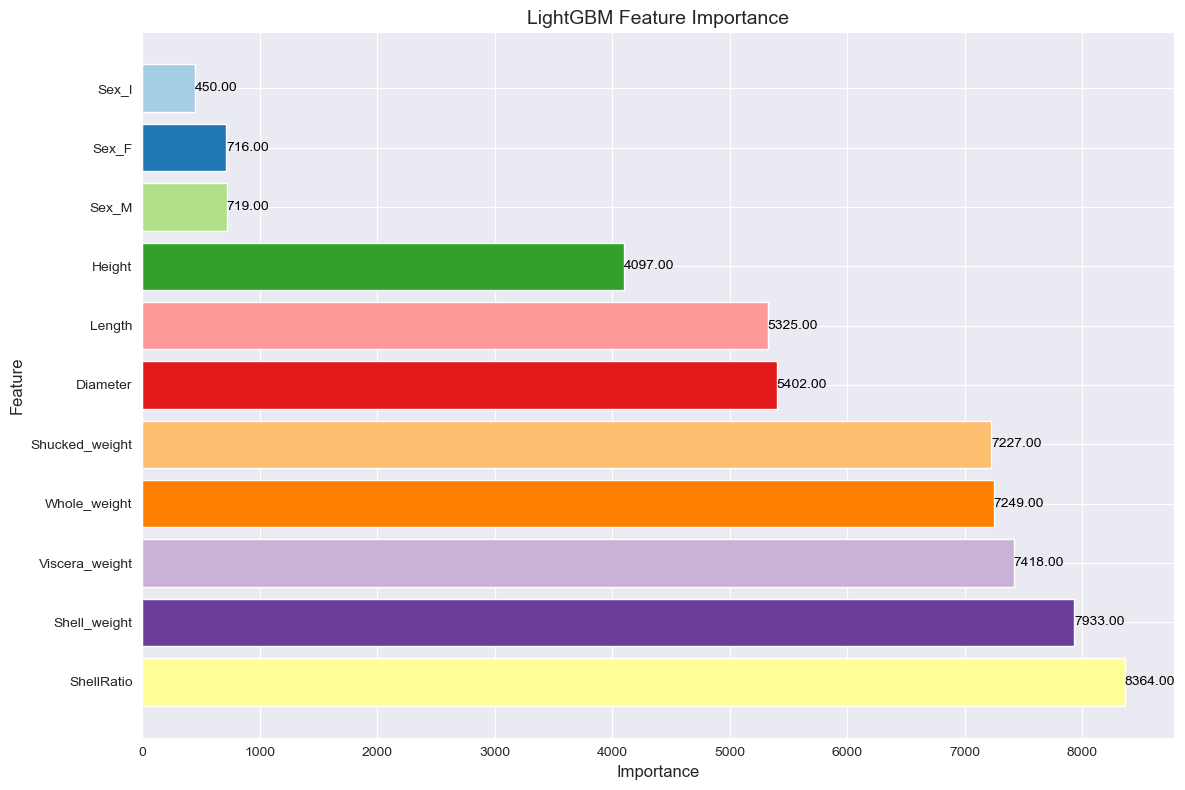

In [134]:
feature_importance = lgb_reg_1.regressor_.feature_importances_

feature_names = X_train.columns

sorted_indices = feature_importance.argsort()
sorted_importance = feature_importance[sorted_indices]
sorted_features = feature_names[sorted_indices]

# Plot feature importance
plt.figure(figsize=(12, 8))
colors = plt.cm.Paired.colors[:len(sorted_features)]  
plt.barh(sorted_features, sorted_importance, color=colors)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('LightGBM Feature Importance', fontsize=14)
plt.gca().invert_yaxis() 

for i, v in enumerate(sorted_importance):
    plt.text(v + 0.02, i, f'{v:.2f}', color='black', va='center', fontsize=10)

plt.tight_layout()  
plt.show()

## catboost

In [127]:
def cb_objective(trial):
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "max_depth": trial.suggest_int("depth", 4, 16),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
    }
    
    cb_reg = TransformedTargetRegressor(CatBoostRegressor(**param, random_state=42, grow_policy='SymmetricTree',
                                                                  random_strength=0, cat_features=["Sex"], loss_function="RMSE"),
                                                     func=np.log1p,
                                                     inverse_func=np.expm1)
    cb_reg = CatBoostRegressor(**param)
    # 使用交叉验证获取得分
    val_scores = cross_val_score(cb_reg, X, y, scoring=rmsle_scorer, cv=kf)

    # 计算平均分数
    avg_score = -np.mean(val_scores)
    
    return avg_score  # 因为rmsle_scorer中设置了greater_is_better=False，返回负的RMSLE分数，Optuna默认是越小越好

sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization
cb_study = optuna.create_study(direction = 'minimize',study_name="CBRegressor", sampler=sampler)

[I 2024-04-29 15:48:57,707] A new study created in memory with name: CBRegressor


In [128]:
if TUNE:
    cb_study.optimize(cb_objective, n_trials=30)

[W 2024-04-29 15:50:41,576] Trial 0 failed with parameters: {'learning_rate': 0.19352465823520762, 'depth': 16, 'l2_leaf_reg': 7.587945476302646, 'n_estimators': 938, 'colsample_bylevel': 0.5780093202212182} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "C:\Users\gusuc\.conda\envs\PS4E4\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gusuc\AppData\Local\Temp\ipykernel_16836\1285134824.py", line 17, in cb_objective
    val_scores = cross_val_score(cb_reg, X, y, scoring=rmsle_scorer, cv=kf)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gusuc\.conda\envs\PS4E4\Lib\site-packages\sklearn\model_selection\_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
                 ^^^^^^^^^^^^^^^
  File "C:\Users\gusuc\.conda\envs\PS4E4\Lib\site-packages\sklearn\model_sele

KeyboardInterrupt: 

In [114]:
print(cb_study.best_params)

{'learning_rate': 0.06756562836526186, 'depth': 6, 'l2_leaf_reg': 2.515448552080745, 'n_estimators': 1233, 'colsample_bylevel': 0.5050897334022381}


In [129]:
cb_params_1 = {
    'depth': 6, 
    'n_estimators': 1233,
    'max_bin': 464, 
    'verbose': False,
    'task_type': 'CPU', 
    'random_state': 42,
    'min_data_in_leaf': 78, 
    'loss_function': 'RMSE', 
    'grow_policy': 'Lossguide', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.83862137638162, 
    'l2_leaf_reg': 2.515448552080745, 
    'random_strength': 3.296124856352495, 
    'learning_rate': 0.06756562836526186,
    'colsample_bylevel': 0.5050897334022381
    }

In [130]:
cat_reg_1 = TransformedTargetRegressor(CatBoostRegressor(**cb_params_1),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)

In [131]:
print("CV RMSLE score of cb_reg_1 is ",np.sqrt(-cross_val_score(cat_reg_1,X,y,cv=4, scoring = 'neg_mean_squared_log_error').mean()))

CV RMSLE score of cb_reg_1 is  0.14909724547318925


In [135]:
cat_reg_1.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=<catboost.core.CatBoostRegressor object at 0x000001DEA10D6C50>)

In [136]:
mean_squared_log_error(y_valid, cat_reg_1.predict(X_valid), squared=False)

0.146576983962829

# Ensembling the Results Using VotingRegressor 使用 VotingRegressor 组合结果

In [149]:
ensemble = VotingRegressor(
    [
        ("xgb", xgb_reg_1),
        ("lgb", lgb_reg_1),
        ("cb", cat_reg_1)
    ],
    weights = [4,5,5]
)

In [150]:
print("CV RMSLE score of Voting is ",np.sqrt(-cross_val_score(ensemble,X,y,cv=4, scoring = 'neg_mean_squared_log_error').mean()))

CV RMSLE score of Voting is  0.14865622715961396


In [180]:
ensemble.fit(X, y)

VotingRegressor(estimators=[('xgb',
                             TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                        inverse_func=<ufunc 'expm1'>,
                                                        regressor=XGBRegressor(base_score=None,
                                                                               booster=None,
                                                                               callbacks=None,
                                                                               colsample_bylevel=None,
                                                                               colsample_bynode=None,
                                                                               colsample_bytree=0.5265780725732072,
                                                                               early_stopping_rounds=None,
                                                                               enable_categorical=False,
                                                                               eta=0.04823193022921833,
                                                                               eval_metric=None...
                                                                                min_child_samples=54,
                                                                                n_estimators=996,
                                                                                n_jobs=-1,
                                                                                num_leaves=59,
                                                                                random_state=42,
                                                                                reg_alpha=0.03519849993125654,
                                                                                reg_lambda=0.009005545129316126,
                                                                                subsample=0.8435839525805869,
                                                                                verbose=-1))),
                            ('cb',
                             TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                        inverse_func=<ufunc 'expm1'>,
                                                        regressor=<catboost.core.CatBoostRegressor object at 0x000001DEA10D6C50>))],
                weights=[4, 5, 5])

# Submit the Output

In [177]:
pred_data.head()

,Sex_F,Sex_M,Sex_I,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,ShellRatio
id,,,,,,,,,,,
90615,0,1,0,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,0.485853
90616,0,1,0,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,0.574713
90617,0,1,0,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,0.682270
90618,0,1,0,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,0.666667
90619,0,0,1,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,0.666667


In [181]:
pred = ensemble.predict(pred_data)

In [184]:
submission = pd.DataFrame(pred_data.index)
submission["Rings"] = pred
submission.to_csv("submission.csv", index=False)